In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal
from torch.autograd import Variable

In [2]:
hidden_dim = 8
batch_size = 100
epochs = 400
samples = torch.stack([torch.normal(torch.ones(2), torch.Tensor([2, 1])) for _ in range(batch_size * 8)])

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # encoder q(z|x)
        self.e1 = nn.Linear(input_dim, hidden_dim)
        self.e2 = nn.Linear(hidden_dim, 2*latent_dim)
        
        # decoder p(x|z)
        self.d1 = nn.Linear(latent_dim, hidden_dim)
        self.d2 = nn.Linear(hidden_dim, 2*input_dim)
        
    def encode(self, x):
        x = F.relu(self.e1(x))
        return self.e2(x).split(self.latent_dim, dim=1)
    
    def decode(self, z):
        x = F.relu(self.d1(z))
        return self.d2(x).split(self.input_dim, dim=1)
    
    def reparameterize(self, avg, log_var):
        std = (log_var * 0.5).exp()
        rv = Variable(avg.data.clone().normal_())
        return rv * std + avg
    
    def forward(self, x):
        avg, log_var = self.encode(x)
        z = self.reparameterize(avg, log_var)
        return (avg, log_var), (self.decode(z))


In [4]:
def plot(epoch, real_batch, fake_batch):
    plt.subplot(4,5, epoch // 20 + 1)
    real_batch = real_batch.data.numpy().T
    fake_batch = fake_batch.data.numpy().T
    plt.scatter(real_batch[0], real_batch[1])
    plt.scatter(fake_batch[0], fake_batch[1])
    plt.xlim(-5, 7)
    plt.ylim(-3, 5)
    plt.title(f"{epoch + 1}th epoch")

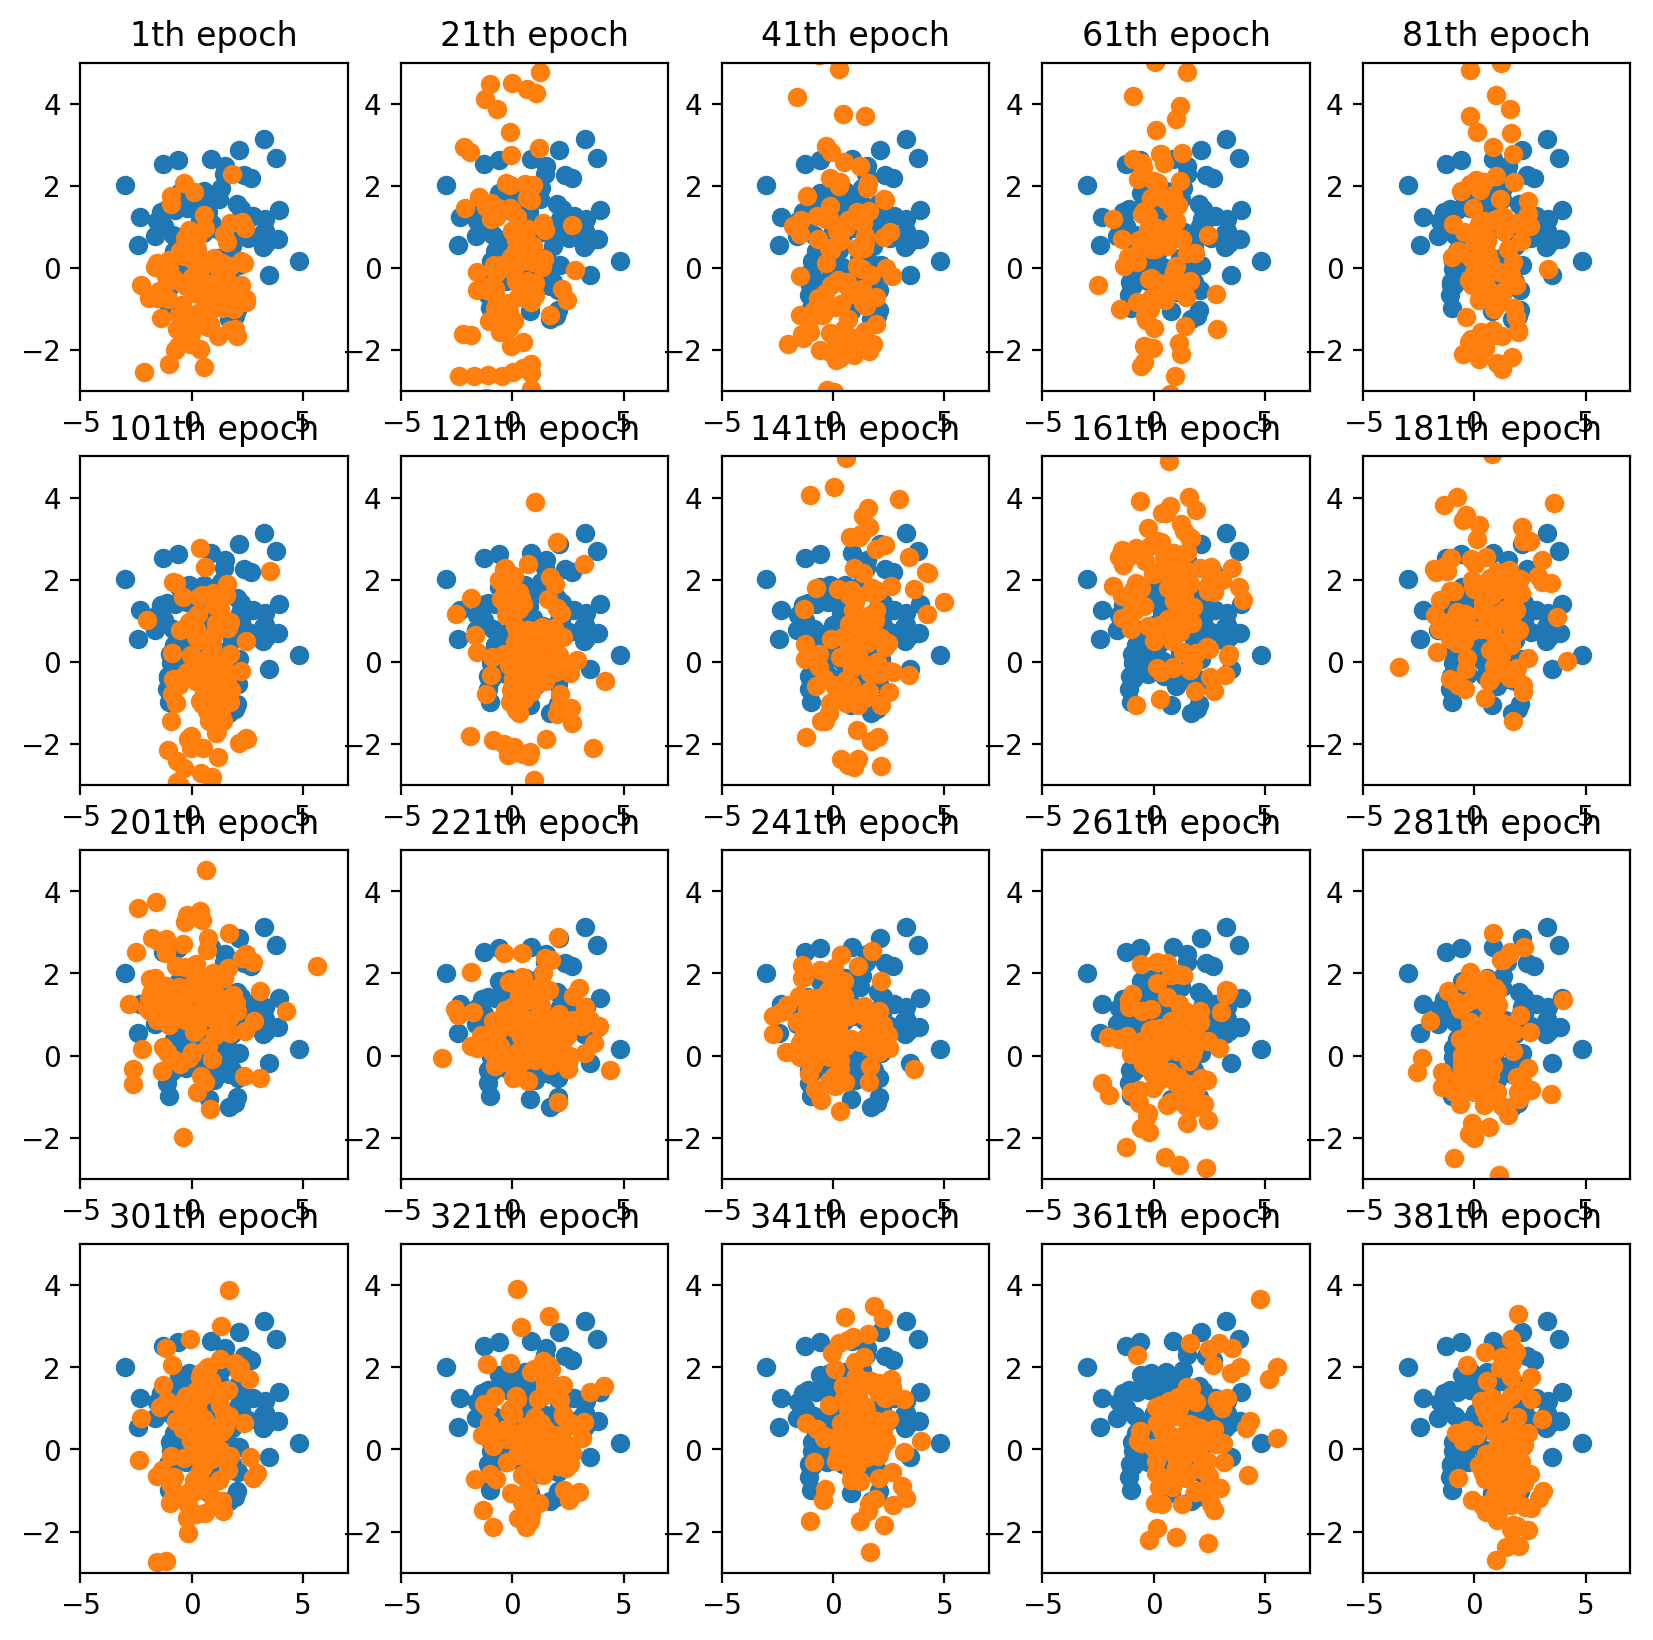

In [5]:
def sample_normal(avg, log_var):
    std = (log_var * 0.5).exp()
    n_dist = Normal(avg, std)
    return n_dist.sample()

def decoder_loss(avg, log_var):
    std = (log_var * 0.5).exp()
    n_dist = Normal(avg, std)
    return - n_dist.log_prob(n_dist.sample()).mean()

def encoder_loss(avg, log_var):
    # See appendix B of Kingma+13
    # KL(q(z|x)||p(z)) = -\frac{1}{2}\sum(1+2\log\sigma-\mu^2-\sigma^2)
    # where p(z) = N(0, 1)
    var = log_var.exp()
    kl = - 0.5 * (1 + log_var - (avg**2) - var).sum(dim=1)
    return kl.mean()

def train_vae():
    plt.figure(figsize=(10,10),dpi=200)
    vae = VAE(2, 2, hidden_dim)
    optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-2)
    for ep in range(epochs):
        for batch_data in samples.split(batch_size):
            x = Variable(batch_data)
            e_val, d_val = vae(x)
            loss = encoder_loss(*e_val) + decoder_loss(*d_val)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if ep % 20 == 0:
            sample = sample_normal(*d_val)
            plot(ep, x, sample)

train_vae()